# Train the network
#### Define the CNN architecture and train it

## Setup

In [1]:
import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, merge, Concatenate
from keras.models import Model
import time

Using TensorFlow backend.


In [2]:
radius = 'ak5' # Jet radius to use. Either 'ak5' or 'ak7'

In [3]:
####################
# Global Variables #
####################
nx = 25 if radius == 'ak5' else 30 # size of image in eta
ny = 25 if radius == 'ak5' else 30 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

### Load and process data

In [4]:
df_jets_train = pd.read_pickle('data/{}/df_jets_{}_train.pkl'.format(radius, radius))
df_jets_val = pd.read_pickle('data/{}/df_jets_{}_val.pkl'.format(radius, radius))

print('Training events = {}, Validation events = {}'.format(df_jets_train.shape[0], df_jets_val.shape[0]))

Training events = 1713015, Validation events = 428254


#### Stack the jet images into the proper input format

In [5]:
jet_images_train = np.stack(df_jets_train['jet_images'])
jet_images_val = np.stack(df_jets_val['jet_images'])

print('Training image shape = {}, Validation image shape = {}'.format(jet_images_train.shape, jet_images_val.shape))

Training image shape = (1713015, 25, 25, 1), Validation image shape = (428254, 25, 25, 1)


### Define the model

In [6]:
model_name = 'standard'

In [7]:
input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(15, (9,9), padding='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, (7,7), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = Convolution2D(6, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)

layer = Flatten()(layer)

# additional features input
jet_eta_input = Input(shape=(1,), name='jet_eta_input')
layer = merge([layer, jet_eta_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_input = Input(shape=(1,), name='jet_pt_input')
layer = merge([layer, jet_pt_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(inputs=[input_layer,jet_pt_input,jet_eta_input], outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mse','msle'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 15)   1230        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 25, 25, 15)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 15)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


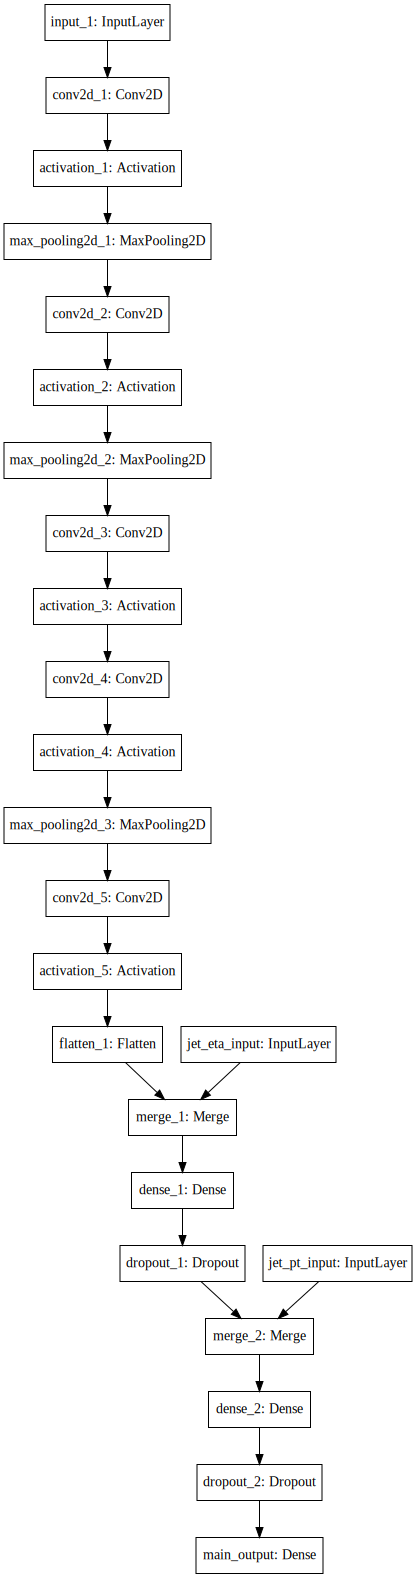

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('models/'+radius+'/'+model_name+'_epoch{epoch:02d}_loss{val_loss:.2f}.h5', 
                             monitor='val_loss', period=5)
bs=256

### Train the model

In [10]:
start = time.clock()
history = model.fit([jet_images_train, df_jets_train['jet_pt'], df_jets_train['jet_eta']],  df_jets_train['gen_pt'],
                    validation_data=([jet_images_val, df_jets_val['jet_pt'], df_jets_val['jet_eta']], df_jets_val['gen_pt']),
                    epochs=400, batch_size=bs, verbose=1, callbacks=[early_stopping, checkpoint])
end = time.clock()

print('Training took {:.2f} minutes'.format((end-start)/60.))

Train on 1713015 samples, validate on 428254 samples
Epoch 1/400
1713015/1713015 [==============================] - 124s 72us/step - loss: 10183.8858 - acc: 0.0000e+00 - mean_squared_error: 10183.8858 - mean_squared_logarithmic_error: 0.4342 - val_loss: 714.1579 - val_acc: 2.3351e-06 - val_mean_squared_error: 714.1579 - val_mean_squared_logarithmic_error: 0.0144
Epoch 2/400
1713015/1713015 [==============================] - 123s 72us/step - loss: 939.4654 - acc: 0.0000e+00 - mean_squared_error: 939.4654 - mean_squared_logarithmic_error: 0.0195 - val_loss: 441.6925 - val_acc: 0.0000e+00 - val_mean_squared_error: 441.6925 - val_mean_squared_logarithmic_error: 0.0111
Epoch 3/400
1713015/1713015 [==============================] - 123s 72us/step - loss: 806.8876 - acc: 0.0000e+00 - mean_squared_error: 806.8876 - mean_squared_logarithmic_error: 0.0164 - val_loss: 437.5479 - val_acc: 0.0000e+00 - val_mean_squared_error: 437.5479 - val_mean_squared_logarithmic_error: 0.0112
Epoch 4/400
1713015

In [11]:
model.save('models/{}/{}_{}_trained.h5'.format(radius, model_name, radius))

## Results

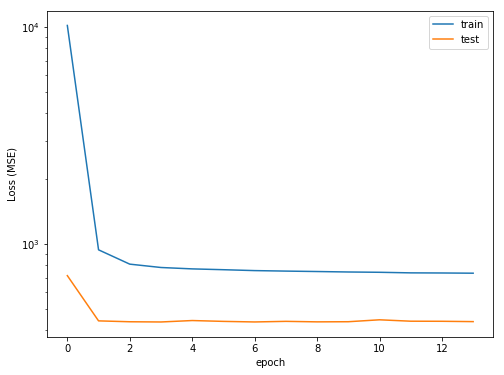

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))

loss = np.asarray(history.history['loss'])
val_loss = np.asarray(history.history['val_loss'])
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

plt.savefig('plots/{}/train_val_loss_{}_{}.pdf'.format(radius, radius, model_name))

#### Make predictions

In [13]:
true_train = df_jets_train['gen_pt']
pred_train = model.predict([jet_images_train, df_jets_train['jet_pt'], df_jets_train['jet_eta']])

true_val = df_jets_val['gen_pt']
pred_val = model.predict([jet_images_val, df_jets_val['jet_pt'], df_jets_val['jet_eta']])

#### Calculate metrics

In [32]:
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(true_train, pred_train)
mse_val = mean_squared_error(true_val, pred_val)

residual_train = (true_train - pred_train[:,0])/true_train
residual_val = (true_val - pred_val[:,0])/true_val

#### Plot figures

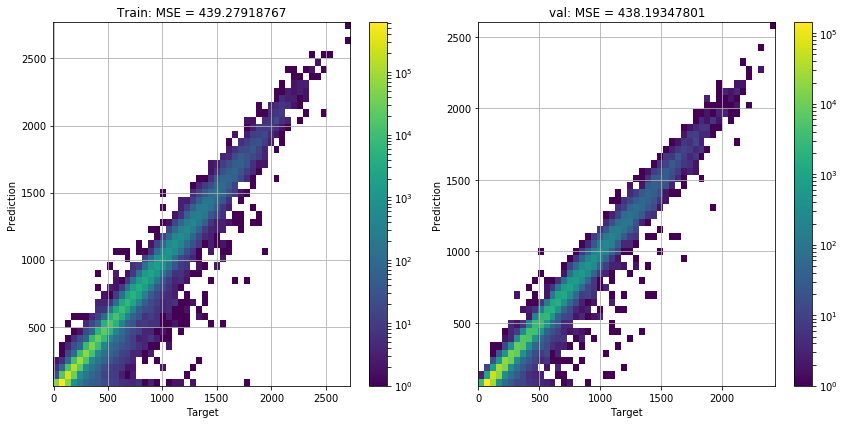

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist2d(true_train, pred_train[:,0], bins=50, norm=LogNorm())
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.hist2d(true_val, pred_val[:,0], bins=50, norm=LogNorm())
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.colorbar()

plt.tight_layout()
plt.show()

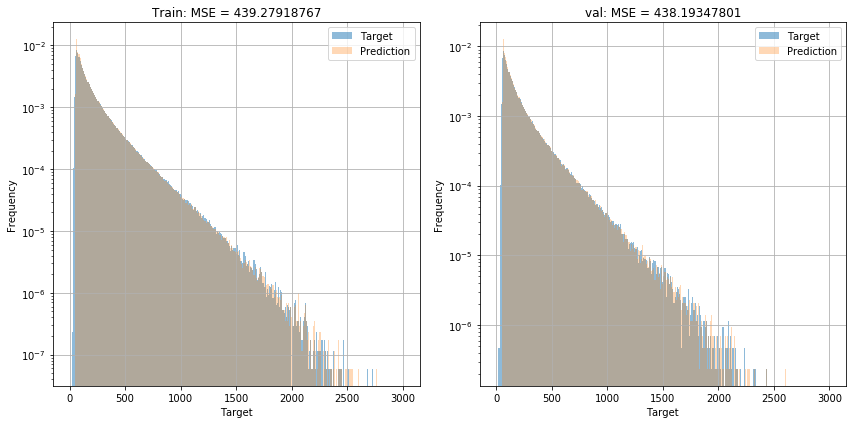

In [34]:
bins = np.linspace(0, 3000, 300)
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist(true_train, bins, label='Target', alpha=0.5, normed=True)
plt.hist(pred_train, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.hist(true_val, bins, label='Target', alpha=0.5, normed=True)
plt.hist(pred_val, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.legend()

plt.tight_layout()
plt.show()

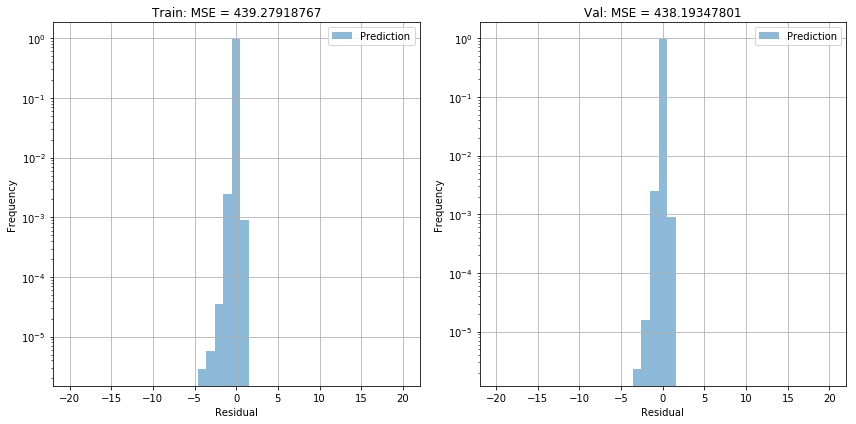

In [38]:
bins = np.linspace(-20, 20, 40)
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist(residual_train, bins, label='Prediction', alpha=0.5, normed=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.hist(residual_val, bins, label='Prediction', alpha=0.5, normed=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.legend()

plt.tight_layout()
plt.show()

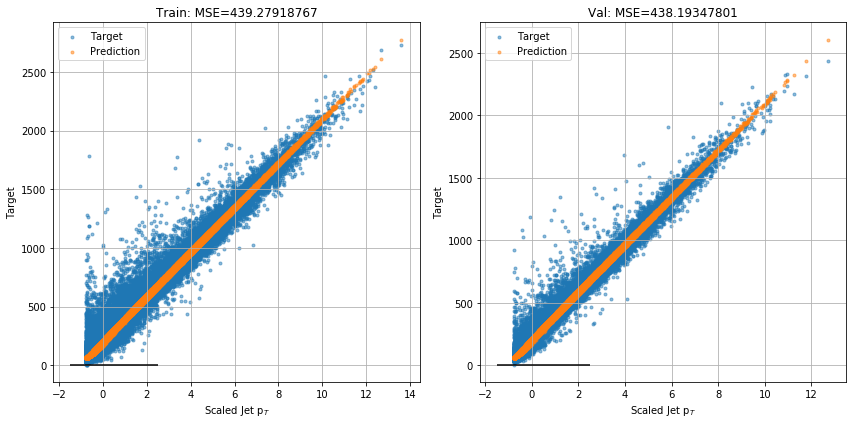

In [43]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.scatter(df_jets_train['jet_pt'], true_train, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_train['jet_pt'], pred_train, label='Prediction', alpha=0.5 , marker='.')
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Target')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.scatter(df_jets_val['jet_pt'], true_val, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_val['jet_pt'], pred_val, label='Prediction', alpha=0.5 , marker='.')
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Target')
plt.legend()

plt.tight_layout()
plt.show()

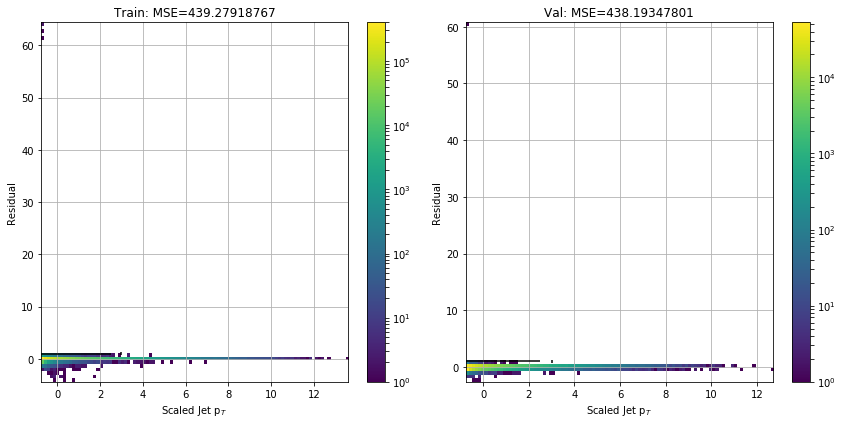

In [53]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.hist2d(df_jets_train['jet_pt'], residual_train, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.hist2d(df_jets_val['jet_pt'], residual_val, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.tight_layout()
plt.show()

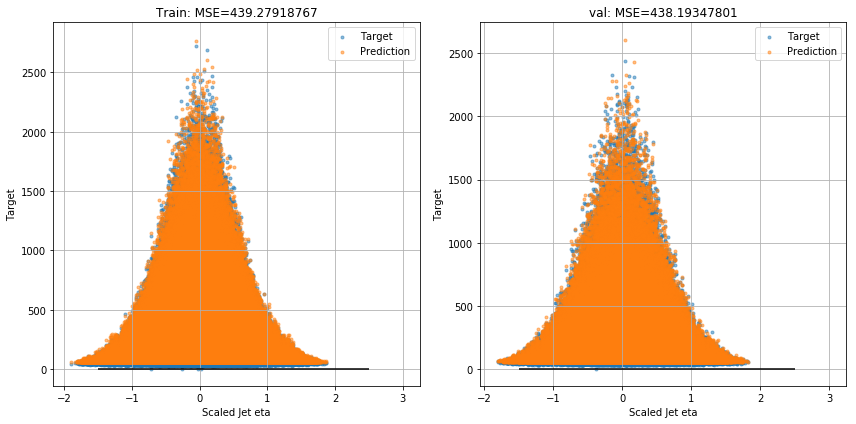

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.scatter(df_jets_train['jet_eta'], true_train, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_train['jet_eta'], pred_train, label='Prediction', alpha=0.5 , marker='.')
#plt.xlim((-1.5,2.5))
#plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Target')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.scatter(df_jets_val['jet_eta'], true_val, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_val['jet_eta'], pred_val, label='Prediction', alpha=0.5 , marker='.')
#plt.xlim((-1.5,2.5))
#plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Target')
plt.legend()

plt.tight_layout()
plt.show()

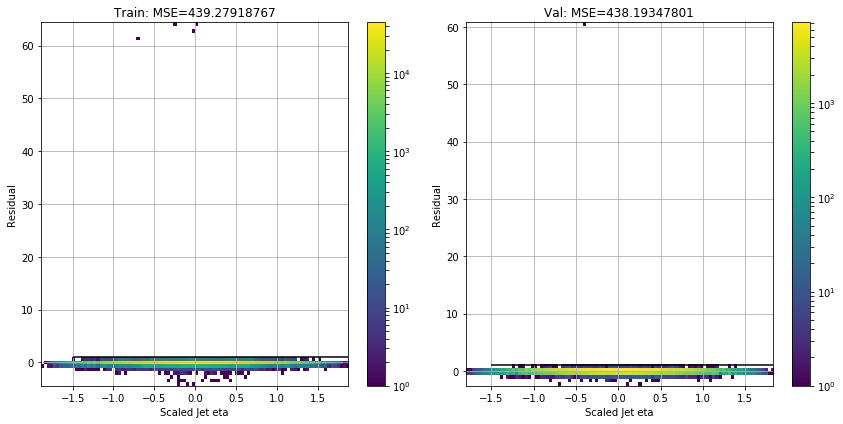

In [54]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.hist2d(df_jets_train['jet_eta'], residual_train, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.hist2d(df_jets_val['jet_eta'], residual_val, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.tight_layout()
plt.show()